In [1]:
from __future__ import division

import pickle
import math

import numpy as np
from scipy.special import digamma, gammaln


def get_preprocessed_data(m=100):
    with open('normalized_tokenized_data.pkl', 'rb') as f:
        documents = pickle.load(f)[:m]
    vocabulary = set()
    for datum in documents:
        vocabulary.update(datum)
    vocabulary = list(vocabulary)
    return documents, vocabulary


def doc_to_match_given_vocabulary(doc, word):
    return (np.array(doc) == word).astype(int)


def initialization(documents, K, M, V, alpha_init=1.0, beta_init=0, dtype=np.float32):
    alpha = np.repeat(alpha_init, K) * 50 / K
    beta = np.full([K, V], beta_init, dtype=dtype)
    for k in range(0, K):
        unnormalized_probability = np.random.uniform(0, 1, V)
        beta[k, :] = unnormalized_probability / np.sum(unnormalized_probability)
    gamma = np.full([M, K], 0, dtype=dtype)
    phi = []
    for m, doc in enumerate(documents):
        gamma[m, :] = alpha + len(doc) / K
        phi += [np.full([len(doc), K], 1 / K)]
    return alpha, beta, phi, gamma


def E_step(alpha, beta, phi, gamma, documents, vocabulary, K, M, V):
    print("E-Step")
    for m, doc in enumerate(documents):
        converge = False
        converge_iteration = 0
        while not converge:
            phi_old = np.array(phi[m], copy=True)
            gamma_old = np.array(gamma[m], copy=True)
            for n in range(len(doc)):
                for i in range(K):
                    word_idx = vocabulary.index(doc[n])
                    phi[m][n][i] = beta[i, word_idx] * math.exp(digamma(gamma[m, i]) - digamma(np.sum(gamma[m, :])))
                if np.sum(phi[m][n]) == 0:
                    print("beta: {0} | digamma: {1} | digamma_sum: {2} | word: {3}".format(beta[i, word_idx],
                                                                               digamma(gamma[m, i]),
                                                                               digamma(np.sum(gamma[m])),
                                                                                vocabulary[word_idx]))
                phi[m][n] = phi[m][n] / np.sum(phi[m][n])  # Normalization
            gamma[m] = alpha + np.sum(phi[m], axis=0)
            phi_error = np.linalg.norm(phi_old - phi[m])
            gamma_error = np.linalg.norm(gamma_old - gamma[m])
            if phi_error < 1e-3 and gamma_error < 1e-3:
                converge = True
                print("Document: {0} | Iteration: {1} | "
                      "Phi_err: {2} | Gamma_err: {3}".format(m, converge_iteration,
                                                             phi_error, gamma_error))
            converge_iteration += 1
    return phi, gamma


def M_step(alpha, beta, phi, gamma, documents, vocabulary, K, M, V):
    print("M-Step")
    beta_old = np.array(beta, copy=True)
    beta = np.zeros([K, V], dtype=np.float32)
    for m, doc in enumerate(documents):
        for j in range(V):
            w_j = doc_to_match_given_vocabulary(doc, vocabulary[j])
            beta[:, j] += np.dot(w_j, phi[m])

    beta = beta / np.sum(beta, axis=1)[:, None]
    if np.any(beta == 0.0):
        print("Skip Updating Beta as there is an element in beta equals to zero.")
        return alpha, beta_old
        
    alpha = alpha
    return alpha, beta


def likelihood_per_document(alpha, beta, phi, gamma, doc, vocabulary, K, M, V):
    gamma_total = -np.log(gammaln(np.sum(gamma))) + np.sum(np.log(gammaln(gamma)))
    alpha_total = np.log(gammaln(np.sum(alpha))) - np.sum(np.log(gammaln(alpha)))
    phi_entropy = -np.sum(phi * np.log(phi))
    phi_digamma_gamma = np.dot(phi, digamma(gamma) - digamma(np.sum(gamma))).sum()
    alpha_digamma_gamma = np.dot(alpha - 1, digamma(gamma) - digamma(np.sum(gamma))).sum()
    gamma_digamma_gamma = np.dot(gamma - 1, digamma(gamma) - digamma(np.sum(gamma))).sum()
    word_matrix = np.zeros([len(doc), len(vocabulary)])
    phi_log_beta = np.dot(phi, np.log(beta))
    if not (np.Infinity in phi_log_beta or -np.Infinity in phi_log_beta):
        for idx, word in enumerate(doc):
            word_matrix[idx, vocabulary.index(word)] = 1
        phi_word_log_beta = np.sum(np.multiply(phi_log_beta, word_matrix))
    else:
        phi_word_log_beta = 0
    return gamma_total + alpha_total + phi_entropy + phi_digamma_gamma + \
           alpha_digamma_gamma + gamma_digamma_gamma + phi_word_log_beta


def get_likelihood(alpha, beta, phi, gamma, documents, vocabulary, K, M, V):
    likelihood_total = 0
    for m, doc in enumerate(documents):
        likelihood_total += likelihood_per_document(alpha, beta, phi[m], gamma[m], doc, vocabulary, K, M, V)
    return likelihood_total


def variational_inference(alpha, beta, phi, gamma, documents, vocabulary, K, M, V):
    likelihood = 0
    likelihood_previous = -1e3
    iteration = 0
    likelihood = get_likelihood(alpha, beta, phi, gamma, documents, vocabulary, K, M, V)
    print("Iteration: {0} | likelihood: {1} | likelihood_previous: {2}".format(-1, likelihood, 'NA'))
    while abs(likelihood - likelihood_previous) > 1e-4:
        likelihood_previous = likelihood
        phi, gamma = E_step(alpha, beta, phi, gamma, documents, vocabulary, K, M, V)
        alpha, beta = M_step(alpha, beta, phi, gamma, documents, vocabulary, K, M, V)
        likelihood = get_likelihood(alpha, beta, phi, gamma, documents, vocabulary, K, M, V)
        print("Iteration: {0} | likelihood: {1} | likelihood_previous: {2}".format(iteration, likelihood, likelihood_previous))
        iteration += 1
    return alpha, beta, phi, gamma


def LDA(documents, vocabulary, K=4):
    M = len(documents)
    V = len(vocabulary)
    alpha, beta, phi, gamma = initialization(documents, K, M, V)
    alpha, beta, phi, gamma = \
        variational_inference(alpha, beta, phi, gamma, documents, vocabulary, K, M, V)
    return alpha, beta, phi, gamma




In [2]:

m = 50
K = 4
documents, vocabulary = get_preprocessed_data(m=m)
print("Number of Vocabulary: {0}".format(len(vocabulary)))
alpha, beta, phi, gamma = LDA(documents, vocabulary, K)

Number of Vocabulary: 4258
Iteration: -1 | likelihood: -122057.19543985819 | likelihood_previous: NA
E-Step
Document: 0 | Iteration: 40 | Phi_err: 5.190933740271186e-05 | Gamma_err: 0.0008592134690843523
Document: 1 | Iteration: 35 | Phi_err: 5.7660519641827486e-05 | Gamma_err: 0.0009289708104915917
Document: 2 | Iteration: 35 | Phi_err: 6.454331832184274e-05 | Gamma_err: 0.0009917626157402992
Document: 3 | Iteration: 25 | Phi_err: 6.317244701652351e-05 | Gamma_err: 0.0008965755696408451
Document: 4 | Iteration: 16 | Phi_err: 0.0001022616463518353 | Gamma_err: 0.0009232434094883502
Document: 5 | Iteration: 42 | Phi_err: 4.007844106717751e-05 | Gamma_err: 0.0008074913057498634
Document: 6 | Iteration: 26 | Phi_err: 6.648690045550527e-05 | Gamma_err: 0.0008541941060684621
Document: 7 | Iteration: 12 | Phi_err: 8.212843396207951e-05 | Gamma_err: 0.0005908933817408979
Document: 8 | Iteration: 3 | Phi_err: 0.00029692884730311397 | Gamma_err: 0.0007090246072039008
Document: 9 | Iteration: 24

Document: 33 | Iteration: 17 | Phi_err: 8.00404278781021e-05 | Gamma_err: 0.0007826639339327812
Document: 34 | Iteration: 37 | Phi_err: 4.775404858327568e-05 | Gamma_err: 0.0007880928460508585
Document: 35 | Iteration: 21 | Phi_err: 7.182576406981439e-05 | Gamma_err: 0.0007916301256045699
Document: 36 | Iteration: 36 | Phi_err: 4.990362708586496e-05 | Gamma_err: 0.0007935395697131753
Document: 37 | Iteration: 26 | Phi_err: 7.553828719405254e-05 | Gamma_err: 0.0009834375232458115
Document: 38 | Iteration: 35 | Phi_err: 5.790936259736774e-05 | Gamma_err: 0.0009539565653540194
Document: 39 | Iteration: 19 | Phi_err: 7.237149181933362e-05 | Gamma_err: 0.0007055772002786398
Document: 40 | Iteration: 42 | Phi_err: 5.217193485117069e-05 | Gamma_err: 0.0009226521942764521
Document: 41 | Iteration: 24 | Phi_err: 7.968461724822078e-05 | Gamma_err: 0.0008796496549621224
Document: 42 | Iteration: 41 | Phi_err: 4.928203680119456e-05 | Gamma_err: 0.000978378695435822
Document: 43 | Iteration: 24 | P

Document: 16 | Iteration: 19 | Phi_err: 7.186091164172406e-05 | Gamma_err: 0.0009771750774234533
Document: 17 | Iteration: 31 | Phi_err: 4.046757633655599e-05 | Gamma_err: 0.0007391486433334649
Document: 18 | Iteration: 19 | Phi_err: 6.899626661015313e-05 | Gamma_err: 0.0008798564085736871
Document: 19 | Iteration: 9 | Phi_err: 8.886837235284256e-05 | Gamma_err: 0.0009754647617228329
Document: 20 | Iteration: 10 | Phi_err: 5.265387665630117e-05 | Gamma_err: 0.00038942156243138015
Document: 21 | Iteration: 4 | Phi_err: 6.923763511426176e-05 | Gamma_err: 0.0001969216245925054
Document: 22 | Iteration: 4 | Phi_err: 9.35251918063873e-05 | Gamma_err: 0.0002482907148078084
Document: 23 | Iteration: 15 | Phi_err: 6.306080200184139e-05 | Gamma_err: 0.000558162690140307
Document: 24 | Iteration: 14 | Phi_err: 6.994106479162817e-05 | Gamma_err: 0.0009486197959631681
Document: 25 | Iteration: 10 | Phi_err: 9.14592905356666e-05 | Gamma_err: 0.0008819213835522532
Document: 26 | Iteration: 26 | Phi_

Iteration: 4 | likelihood: -98824.98139662191 | likelihood_previous: -101042.76618208113
E-Step
Document: 0 | Iteration: 6 | Phi_err: 4.8907027820598396e-05 | Gamma_err: 0.00046846672194078565
Document: 1 | Iteration: 15 | Phi_err: 4.8059690988845896e-05 | Gamma_err: 0.0005229231901466846
Document: 2 | Iteration: 17 | Phi_err: 5.2821747379667846e-05 | Gamma_err: 0.0006359856342896819
Document: 3 | Iteration: 10 | Phi_err: 7.184062048061619e-05 | Gamma_err: 0.0006482347962446511
Document: 4 | Iteration: 12 | Phi_err: 8.448857809535991e-05 | Gamma_err: 0.0006883203168399632
Document: 5 | Iteration: 8 | Phi_err: 6.624048971236795e-05 | Gamma_err: 0.0008027853327803314
Document: 6 | Iteration: 7 | Phi_err: 0.00011255320144174639 | Gamma_err: 0.0009109641541726887
Document: 7 | Iteration: 10 | Phi_err: 8.417953894910127e-05 | Gamma_err: 0.0005882307887077332
Document: 8 | Iteration: 3 | Phi_err: 5.1529750260513195e-05 | Gamma_err: 0.00010107148409588262
Document: 9 | Iteration: 8 | Phi_err:

Document: 33 | Iteration: 15 | Phi_err: 6.137340343449846e-05 | Gamma_err: 0.0005647974321618676
Document: 34 | Iteration: 4 | Phi_err: 6.915023436453894e-05 | Gamma_err: 0.0005385245895013213
Document: 35 | Iteration: 5 | Phi_err: 0.0001639539733980657 | Gamma_err: 0.0009362935088574886
Document: 36 | Iteration: 7 | Phi_err: 8.964341101504646e-05 | Gamma_err: 0.0009334596106782556
Document: 37 | Iteration: 17 | Phi_err: 4.6120760962986545e-05 | Gamma_err: 0.0005826629931107163
Document: 38 | Iteration: 11 | Phi_err: 8.5014757543941e-05 | Gamma_err: 0.0007745831971988082
Document: 39 | Iteration: 7 | Phi_err: 0.00010969005440593146 | Gamma_err: 0.0005137039115652442
Document: 40 | Iteration: 10 | Phi_err: 8.724332678960454e-05 | Gamma_err: 0.0009751383913680911
Document: 41 | Iteration: 7 | Phi_err: 7.564606393289557e-05 | Gamma_err: 0.0005588368512690067
Document: 42 | Iteration: 17 | Phi_err: 5.78926796090828e-05 | Gamma_err: 0.0007733798702247441
Document: 43 | Iteration: 9 | Phi_er

Document: 17 | Iteration: 8 | Phi_err: 5.111839597712807e-05 | Gamma_err: 0.0005102050490677357
Document: 18 | Iteration: 10 | Phi_err: 8.562902292901522e-05 | Gamma_err: 0.0007586189894936979
Document: 19 | Iteration: 5 | Phi_err: 3.3408578490812025e-05 | Gamma_err: 0.00029994535725563765
Document: 20 | Iteration: 5 | Phi_err: 0.00014512693581748118 | Gamma_err: 0.0007124119438230991
Document: 21 | Iteration: 2 | Phi_err: 0.0003556927398792635 | Gamma_err: 0.0007388619123958051
Document: 22 | Iteration: 2 | Phi_err: 0.00016480868652001053 | Gamma_err: 0.0002710734261199832
Document: 23 | Iteration: 4 | Phi_err: 0.00010734580811015122 | Gamma_err: 0.0006115521537140012
Document: 24 | Iteration: 6 | Phi_err: 7.441862505050779e-05 | Gamma_err: 0.0008114042575471103
Document: 25 | Iteration: 7 | Phi_err: 5.711542629794641e-05 | Gamma_err: 0.00044275555410422385
Document: 26 | Iteration: 8 | Phi_err: 3.765743841112771e-05 | Gamma_err: 0.00038990704342722893
Document: 27 | Iteration: 8 | Ph

Document: 0 | Iteration: 4 | Phi_err: 4.994220563494907e-05 | Gamma_err: 0.0004316216509323567
Document: 1 | Iteration: 6 | Phi_err: 0.00012779615664614783 | Gamma_err: 0.0009923254838213325
Document: 2 | Iteration: 8 | Phi_err: 5.463359631204254e-05 | Gamma_err: 0.000433782406616956
Document: 3 | Iteration: 6 | Phi_err: 6.392556455977195e-05 | Gamma_err: 0.0005108597688376904
Document: 4 | Iteration: 5 | Phi_err: 0.00018319565630012965 | Gamma_err: 0.0008895486244000494
Document: 5 | Iteration: 7 | Phi_err: 3.506011924145403e-05 | Gamma_err: 0.0004128738073632121
Document: 6 | Iteration: 4 | Phi_err: 7.514895110088488e-05 | Gamma_err: 0.0004321396991144866
Document: 7 | Iteration: 6 | Phi_err: 9.311829312532878e-05 | Gamma_err: 0.0004981832462362945
Document: 8 | Iteration: 2 | Phi_err: 0.00016738340051880365 | Gamma_err: 0.0003347722813487053
Document: 9 | Iteration: 5 | Phi_err: 0.00012173542109170685 | Gamma_err: 0.0009041134035214782
Document: 10 | Iteration: 7 | Phi_err: 0.000109

Document: 35 | Iteration: 5 | Phi_err: 6.265054019458669e-05 | Gamma_err: 0.0003948211669921875
Document: 36 | Iteration: 6 | Phi_err: 7.859814473870133e-05 | Gamma_err: 0.0007652866770513356
Document: 37 | Iteration: 9 | Phi_err: 6.186367554176679e-05 | Gamma_err: 0.0004748570208903402
Document: 38 | Iteration: 8 | Phi_err: 5.373994339467029e-05 | Gamma_err: 0.0004666849854402244
Document: 39 | Iteration: 4 | Phi_err: 0.00014379556494968323 | Gamma_err: 0.0008896677172742784
Document: 40 | Iteration: 9 | Phi_err: 7.114822435143609e-05 | Gamma_err: 0.0007628846215084195
Document: 41 | Iteration: 6 | Phi_err: 4.214210226196162e-05 | Gamma_err: 0.00030518771382048726
Document: 42 | Iteration: 7 | Phi_err: 5.2832665851981684e-05 | Gamma_err: 0.0005807054112665355
Document: 43 | Iteration: 4 | Phi_err: 0.0001704614112495098 | Gamma_err: 0.0009758861269801855
Document: 44 | Iteration: 6 | Phi_err: 7.947605984349405e-05 | Gamma_err: 0.0006147997337393463
Document: 45 | Iteration: 11 | Phi_er

Document: 19 | Iteration: 3 | Phi_err: 8.570439699442841e-05 | Gamma_err: 0.0007140161469578743
Document: 20 | Iteration: 5 | Phi_err: 0.00011611188210705843 | Gamma_err: 0.0005871544126421213
Document: 21 | Iteration: 2 | Phi_err: 0.0001402736567882144 | Gamma_err: 0.0002664389321580529
Document: 22 | Iteration: 1 | Phi_err: 0.0002250552099585223 | Gamma_err: 0.0003180514613632113
Document: 23 | Iteration: 3 | Phi_err: 7.474727950307347e-05 | Gamma_err: 0.0003002363082487136
Document: 24 | Iteration: 7 | Phi_err: 4.750352033161222e-05 | Gamma_err: 0.0005403051036410034
Document: 25 | Iteration: 6 | Phi_err: 8.8905924423635e-05 | Gamma_err: 0.0006595814484171569
Document: 26 | Iteration: 6 | Phi_err: 4.1841090477317764e-05 | Gamma_err: 0.00037339242408052087
Document: 27 | Iteration: 5 | Phi_err: 9.500311372899322e-05 | Gamma_err: 0.0006390301277860999
Document: 28 | Iteration: 3 | Phi_err: 8.136986750737805e-05 | Gamma_err: 0.0007524266839027405
Document: 29 | Iteration: 5 | Phi_err: 

Document: 3 | Iteration: 5 | Phi_err: 4.1208148080175904e-05 | Gamma_err: 0.0003621401556301862
Document: 4 | Iteration: 5 | Phi_err: 6.960959933851126e-05 | Gamma_err: 0.0003302853729110211
Document: 5 | Iteration: 6 | Phi_err: 6.624179628719988e-05 | Gamma_err: 0.0006330357864499092
Document: 6 | Iteration: 4 | Phi_err: 9.005019069319959e-05 | Gamma_err: 0.0007435479783453047
Document: 7 | Iteration: 5 | Phi_err: 7.804933470069535e-05 | Gamma_err: 0.00040327233728021383
Document: 8 | Iteration: 2 | Phi_err: 0.00011554464592865378 | Gamma_err: 0.00021486687182914466
Document: 9 | Iteration: 5 | Phi_err: 6.269924952944397e-05 | Gamma_err: 0.00047754234401509166
Document: 10 | Iteration: 4 | Phi_err: 0.00019380830836373845 | Gamma_err: 0.0008736031595617533
Document: 11 | Iteration: 4 | Phi_err: 0.00010738479397844514 | Gamma_err: 0.0006891133380122483
Document: 12 | Iteration: 8 | Phi_err: 7.621927598215435e-05 | Gamma_err: 0.0005398874636739492
Document: 13 | Iteration: 3 | Phi_err: 7

Document: 38 | Iteration: 5 | Phi_err: 8.265655739456406e-05 | Gamma_err: 0.0006309779128059745
Document: 39 | Iteration: 4 | Phi_err: 0.00014087396828941798 | Gamma_err: 0.0008877560612745583
Document: 40 | Iteration: 5 | Phi_err: 4.344400659662585e-05 | Gamma_err: 0.000479826150694862
Document: 41 | Iteration: 5 | Phi_err: 6.525516831115177e-05 | Gamma_err: 0.0004782275063917041
Document: 42 | Iteration: 4 | Phi_err: 3.903646517186483e-05 | Gamma_err: 0.0003682072274386883
Document: 43 | Iteration: 3 | Phi_err: 0.00019773225066066792 | Gamma_err: 0.0009716064669191837
Document: 44 | Iteration: 6 | Phi_err: 6.0188207470046446e-05 | Gamma_err: 0.00045209392555989325
Document: 45 | Iteration: 7 | Phi_err: 5.1638522340965785e-05 | Gamma_err: 0.0003280251403339207
Document: 46 | Iteration: 3 | Phi_err: 0.00016076993884661393 | Gamma_err: 0.0009333256166428328
Document: 47 | Iteration: 3 | Phi_err: 4.466239271653821e-05 | Gamma_err: 0.0003872258239425719
Document: 48 | Iteration: 10 | Phi_

Document: 23 | Iteration: 3 | Phi_err: 8.718984454431212e-05 | Gamma_err: 0.00042070442577823997
Document: 24 | Iteration: 5 | Phi_err: 3.677178982113813e-05 | Gamma_err: 0.00043848282075487077
Document: 25 | Iteration: 4 | Phi_err: 9.567117052601997e-05 | Gamma_err: 0.000772393774241209
Document: 26 | Iteration: 4 | Phi_err: 4.598157476644742e-05 | Gamma_err: 0.00036969612119719386
Document: 27 | Iteration: 4 | Phi_err: 0.00014845354191203404 | Gamma_err: 0.0009553474956192076
Document: 28 | Iteration: 2 | Phi_err: 7.368510534356609e-05 | Gamma_err: 0.0007526877452619374
Document: 29 | Iteration: 4 | Phi_err: 6.931057789803589e-05 | Gamma_err: 0.0006237176130525768
Document: 30 | Iteration: 3 | Phi_err: 4.8319034993481816e-05 | Gamma_err: 0.0003962513874284923
Document: 31 | Iteration: 7 | Phi_err: 6.157856701717334e-05 | Gamma_err: 0.0006368888425640762
Document: 32 | Iteration: 6 | Phi_err: 5.702164869912771e-05 | Gamma_err: 0.00036247153184376657
Document: 33 | Iteration: 5 | Phi_e

Document: 7 | Iteration: 4 | Phi_err: 0.0001378206175230135 | Gamma_err: 0.0007240567938424647
Document: 8 | Iteration: 2 | Phi_err: 7.311018623919588e-05 | Gamma_err: 0.00012595001317095011
Document: 9 | Iteration: 4 | Phi_err: 5.379635088939751e-05 | Gamma_err: 0.00040763747529126704
Document: 10 | Iteration: 4 | Phi_err: 8.324218090816192e-05 | Gamma_err: 0.00037942337803542614
Document: 11 | Iteration: 3 | Phi_err: 0.0001413806250043832 | Gamma_err: 0.0009179465705528855
Document: 12 | Iteration: 7 | Phi_err: 6.911407483523401e-05 | Gamma_err: 0.0005162893794476986
Document: 13 | Iteration: 2 | Phi_err: 0.00029641303874906096 | Gamma_err: 0.0009151080157607794
Document: 14 | Iteration: 3 | Phi_err: 6.0666650390002134e-05 | Gamma_err: 0.00047085247933864594
Document: 15 | Iteration: 2 | Phi_err: 7.223161189521318e-05 | Gamma_err: 0.0004531026934273541
Document: 16 | Iteration: 3 | Phi_err: 4.230004598200072e-05 | Gamma_err: 0.000353148061549291
Document: 17 | Iteration: 3 | Phi_err:

Document: 42 | Iteration: 2 | Phi_err: 3.463623343336451e-05 | Gamma_err: 0.0003226521366741508
Document: 43 | Iteration: 3 | Phi_err: 0.00012767747225576716 | Gamma_err: 0.0006953534903004766
Document: 44 | Iteration: 5 | Phi_err: 6.14655319459259e-05 | Gamma_err: 0.0005077740643173456
Document: 45 | Iteration: 5 | Phi_err: 8.494693423430389e-05 | Gamma_err: 0.0006426066975109279
Document: 46 | Iteration: 2 | Phi_err: 0.00012782899101478605 | Gamma_err: 0.000657971715554595
Document: 47 | Iteration: 2 | Phi_err: 3.348426275382803e-05 | Gamma_err: 0.0003008430649060756
Document: 48 | Iteration: 8 | Phi_err: 5.4066417038916e-05 | Gamma_err: 0.0005325910169631243
Document: 49 | Iteration: 4 | Phi_err: 5.929789967128575e-05 | Gamma_err: 0.00066361203789711
M-Step
Iteration: 21 | likelihood: -95651.64875919698 | likelihood_previous: -95654.52219640132
E-Step
Document: 0 | Iteration: 1 | Phi_err: 0.00013581259770410108 | Gamma_err: 0.0008867017459124327
Document: 1 | Iteration: 4 | Phi_err:

Document: 26 | Iteration: 2 | Phi_err: 0.00010000651636942849 | Gamma_err: 0.0008999067940749228
Document: 27 | Iteration: 4 | Phi_err: 7.220132685098746e-05 | Gamma_err: 0.0004453281289897859
Document: 28 | Iteration: 2 | Phi_err: 3.3041687527008874e-05 | Gamma_err: 0.0003715072525665164
Document: 29 | Iteration: 3 | Phi_err: 6.968120036083407e-05 | Gamma_err: 0.0006604964146390557
Document: 30 | Iteration: 2 | Phi_err: 9.418754048951276e-05 | Gamma_err: 0.000833928061183542
Document: 31 | Iteration: 5 | Phi_err: 6.316641083751316e-05 | Gamma_err: 0.0006438227137550712
Document: 32 | Iteration: 5 | Phi_err: 6.918450682601683e-05 | Gamma_err: 0.00042733974987640977
Document: 33 | Iteration: 3 | Phi_err: 8.8809186586389e-05 | Gamma_err: 0.0005754853482358158
Document: 34 | Iteration: 1 | Phi_err: 5.5556367708192916e-05 | Gamma_err: 0.0003281596000306308
Document: 35 | Iteration: 3 | Phi_err: 4.517320673058162e-05 | Gamma_err: 0.0003074560663662851
Document: 36 | Iteration: 3 | Phi_err: 

Document: 11 | Iteration: 3 | Phi_err: 4.869196027416373e-05 | Gamma_err: 0.0003148757677990943
Document: 12 | Iteration: 6 | Phi_err: 0.00011287951096761829 | Gamma_err: 0.0009128650999628007
Document: 13 | Iteration: 2 | Phi_err: 0.0001270190058715642 | Gamma_err: 0.00040421055746264756
Document: 14 | Iteration: 2 | Phi_err: 5.453781303327491e-05 | Gamma_err: 0.0003924992633983493
Document: 15 | Iteration: 2 | Phi_err: 9.897013527553953e-05 | Gamma_err: 0.0007369477534666657
Document: 16 | Iteration: 1 | Phi_err: 0.00011310071194623136 | Gamma_err: 0.0009363392018713057
Document: 17 | Iteration: 1 | Phi_err: 8.65781607721754e-05 | Gamma_err: 0.0008130452479235828
Document: 18 | Iteration: 5 | Phi_err: 0.00011477241875913817 | Gamma_err: 0.0009821956045925617
Document: 19 | Iteration: 1 | Phi_err: 5.841052567362362e-05 | Gamma_err: 0.000450562423793599
Document: 20 | Iteration: 4 | Phi_err: 6.49066237908062e-05 | Gamma_err: 0.0003315825597383082
Document: 21 | Iteration: 2 | Phi_err: 

Document: 47 | Iteration: 1 | Phi_err: 5.0203364077879864e-05 | Gamma_err: 0.0003668536082841456
Document: 48 | Iteration: 6 | Phi_err: 7.653358052227198e-05 | Gamma_err: 0.0007970298756845295
Document: 49 | Iteration: 2 | Phi_err: 6.316215956926465e-05 | Gamma_err: 0.0006532216793857515
M-Step
Iteration: 26 | likelihood: -95645.22785867893 | likelihood_previous: -95645.98960645912
E-Step
Document: 0 | Iteration: 1 | Phi_err: 5.9859785646493084e-05 | Gamma_err: 0.00038404547376558185
Document: 1 | Iteration: 3 | Phi_err: 6.2231686335945e-05 | Gamma_err: 0.00060691760154441
Document: 2 | Iteration: 2 | Phi_err: 5.6749972946165184e-05 | Gamma_err: 0.0003990053082816303
Document: 3 | Iteration: 3 | Phi_err: 8.823413725074779e-05 | Gamma_err: 0.0007135268533602357
Document: 4 | Iteration: 3 | Phi_err: 6.814930002304966e-05 | Gamma_err: 0.0003935983986593783
Document: 5 | Iteration: 3 | Phi_err: 4.1936049503329414e-05 | Gamma_err: 0.0004987999564036727
Document: 6 | Iteration: 2 | Phi_err: 

Document: 31 | Iteration: 3 | Phi_err: 7.832031667954878e-05 | Gamma_err: 0.0008475262438878417
Document: 32 | Iteration: 4 | Phi_err: 0.00010497317105311782 | Gamma_err: 0.0006401733844541013
Document: 33 | Iteration: 2 | Phi_err: 4.470143479842282e-05 | Gamma_err: 0.00029312417609617114
Document: 34 | Iteration: 0 | Phi_err: 0.0004907464783517434 | Gamma_err: 0.0005063175340183079
Document: 35 | Iteration: 2 | Phi_err: 5.9197883034835834e-05 | Gamma_err: 0.0003890149528160691
Document: 36 | Iteration: 2 | Phi_err: 6.34034884607657e-05 | Gamma_err: 0.0006395877571776509
Document: 37 | Iteration: 2 | Phi_err: 4.8452224660888915e-05 | Gamma_err: 0.0003158332547172904
Document: 38 | Iteration: 3 | Phi_err: 8.202387655739607e-05 | Gamma_err: 0.0008736072923056781
Document: 39 | Iteration: 4 | Phi_err: 9.651883547339754e-05 | Gamma_err: 0.0005947166937403381
Document: 40 | Iteration: 2 | Phi_err: 4.73605880042385e-05 | Gamma_err: 0.0005443200352601707
Document: 41 | Iteration: 4 | Phi_err:

Document: 15 | Iteration: 0 | Phi_err: 7.083233882343504e-06 | Gamma_err: 5.333759690984152e-05
Document: 16 | Iteration: 0 | Phi_err: 2.698375272518993e-06 | Gamma_err: 1.954450817720499e-05
Document: 17 | Iteration: 0 | Phi_err: 7.277072839152345e-06 | Gamma_err: 5.986158430459909e-05
Document: 18 | Iteration: 0 | Phi_err: 1.4268306398502203e-05 | Gamma_err: 0.00012174204312032089
Document: 19 | Iteration: 0 | Phi_err: 5.937197019145803e-06 | Gamma_err: 3.673812898341566e-05
Document: 20 | Iteration: 0 | Phi_err: 1.1580959209605488e-05 | Gamma_err: 5.3686020692111924e-05
Document: 21 | Iteration: 0 | Phi_err: 1.6340312916873215e-06 | Gamma_err: 2.1324806311895372e-06
Document: 22 | Iteration: 0 | Phi_err: 1.5366409146712334e-06 | Gamma_err: 2.523185003155959e-06
Document: 23 | Iteration: 0 | Phi_err: 4.548932780953615e-06 | Gamma_err: 2.8737104003084823e-05
Document: 24 | Iteration: 0 | Phi_err: 7.1308153157642035e-06 | Gamma_err: 8.069685281952843e-05
Document: 25 | Iteration: 0 | P

Skip Updating Beta as there is an element in beta equals to zero.
Iteration: 31 | likelihood: -95644.13795779666 | likelihood_previous: -95644.1374761647
E-Step
Document: 0 | Iteration: 0 | Phi_err: 3.0543017006404605e-07 | Gamma_err: 2.6973982585332124e-06
Document: 1 | Iteration: 0 | Phi_err: 1.5787040163139657e-06 | Gamma_err: 9.5367431640625e-06
Document: 2 | Iteration: 0 | Phi_err: 1.7882340624973606e-06 | Gamma_err: 1.206313208967913e-05
Document: 3 | Iteration: 0 | Phi_err: 1.3152789668887244e-06 | Gamma_err: 7.62939453125e-06
Document: 4 | Iteration: 0 | Phi_err: 1.0471427452578462e-06 | Gamma_err: 4.2649612623790745e-06
Document: 5 | Iteration: 0 | Phi_err: 5.890462966054791e-07 | Gamma_err: 4.2649612623790745e-06
Document: 6 | Iteration: 0 | Phi_err: 8.091926589410937e-07 | Gamma_err: 1.5843626897549257e-05
Document: 7 | Iteration: 0 | Phi_err: 1.4277599561038015e-06 | Gamma_err: 8.529922524758149e-06
Document: 8 | Iteration: 0 | Phi_err: 0.0 | Gamma_err: 0.0
Document: 9 | It

Document: 41 | Iteration: 0 | Phi_err: 0.0 | Gamma_err: 0.0
Document: 42 | Iteration: 0 | Phi_err: 2.0016281153113526e-07 | Gamma_err: 0.0
Document: 43 | Iteration: 0 | Phi_err: 3.974747560156727e-07 | Gamma_err: 2.6973982585332124e-06
Document: 44 | Iteration: 0 | Phi_err: 3.78562874826904e-07 | Gamma_err: 2.6973982585332124e-06
Document: 45 | Iteration: 0 | Phi_err: 0.0 | Gamma_err: 0.0
Document: 46 | Iteration: 0 | Phi_err: 2.1089556608118382e-07 | Gamma_err: 0.0
Document: 47 | Iteration: 0 | Phi_err: 0.0 | Gamma_err: 0.0
Document: 48 | Iteration: 0 | Phi_err: 6.777194494381781e-07 | Gamma_err: 1.561232056701556e-05
Document: 49 | Iteration: 0 | Phi_err: 1.1294208253060108e-06 | Gamma_err: 9.5367431640625e-06
M-Step
Skip Updating Beta as there is an element in beta equals to zero.
Iteration: 33 | likelihood: -95644.13830077613 | likelihood_previous: -95644.13833475187


In [7]:
for k in range(K):
    word_idx = np.where(np.argmax(beta, axis=0)==k)
    top_n_word = np.argsort(beta[k][word_idx])[-20:][::-1]
    print(np.array(vocabulary)[top_n_word])

['tinkerbell' 'problem' 'standard' 'warm' 'highways' 'great' 'around'
 'solar' 'desperate' 'imports' 'trilby' 'destroying' 'unemployed'
 'straight' 'prevent' 'dispatched' 'ang' 'extremely' 'monomer' 'amtrak']
['bruce' 'appointment' 'man' 'scars' 'tony' 'jammed' 'backstage' 'craft'
 'chest' 'sears' 'exploded' 'patrol' 'print' 'portion' 'something'
 'rumors' 'guided' 'investment' 'trail' 'adversely']
['legs' 'spot' 'aspin' 'summer' 'retail' 'princeton' 'shake' 'aubrey'
 'afford' 'pros' 'invasion' 'written' 'close' 'art' 'asked' 'attributed'
 'little' 'shaken' 'motor' 'barrels']
['last' 'warm' 'happened' 'several' 'proof' 'legislative' 'white'
 'counted' 'strong' 'fleet' 'automatically' 'driven' 'upset' 'assurances'
 'boost' 'kgb' 'gayle' 'flows' 'blandon' 'guarded']


In [8]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [9]:
group = KMeans(n_clusters=3, random_state=0).fit_predict(gamma)
dot = PCA(n_components=2).fit_transform(gamma)

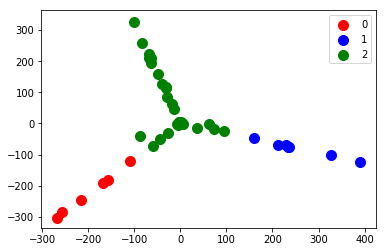

In [10]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

cdict = {0: 'red', 1: 'blue', 2: 'green'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(dot[ix, 0], dot[ix, 1], c = cdict[g], label = g, s = 100)
ax.legend()
plt.show()

In [11]:
ix_0 = np.where(group == 0)
ix_1 = np.where(group == 1)
ix_2 = np.where(group == 2)

In [12]:
ix_0

(array([ 5, 17, 28, 36, 37, 47], dtype=int64),)

In [13]:
ix_1

(array([ 0,  2, 19, 25, 29, 34, 42], dtype=int64),)

In [14]:
ix_2

(array([ 1,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21,
        22, 23, 24, 26, 27, 30, 31, 32, 33, 35, 38, 39, 40, 41, 43, 44, 45,
        46, 48, 49], dtype=int64),)

In [18]:
documents[19]

['nasa',
 'scientists',
 'rejoiced',
 'pretty',
 'damn',
 'good',
 'test',
 'photos',
 'magellan',
 'probe',
 'today',
 'also',
 'grappled',
 'communications',
 'difficulties',
 'spacecraft',
 'circled',
 'venus',
 'fifteen',
 'hours',
 'spacecraft',
 'lost',
 'contact',
 'earth',
 'thursday',
 'evening',
 'signal',
 'established',
 'signal',
 'failed',
 'midday',
 'expected',
 'continue',
 'problem',
 'scientists',
 'could',
 'send',
 'magellan',
 'new',
 'instructions',
 'properly',
 'aim',
 'earth',
 'officials',
 'said',
 'meanwhile',
 'project',
 'manager',
 'tony',
 'spear',
 'said',
 'test',
 'pictures',
 'collected',
 'spacecraft',
 'radar',
 'mapper',
 'problems',
 'developed',
 'produced',
 'raw',
 'images',
 'looked',
 'pretty',
 'damn',
 'good',
 'said',
 'nasa',
 'release',
 'first',
 'pictures',
 'monday',
 'instead',
 'waiting',
 'september',
 'thursday',
 'test',
 'returned',
 'far',
 'pictures',
 'expected',
 'including',
 'several',
 'called',
 'noodles',
 'areas',
 '